# Cafe Sales Data Cleaning – Production-Ready Edition

**Objective:** Clean the dirty cafe sales dataset while avoiding common analytical traps, and produce reliable, time‑aware insights for business decisions.

**Key improvements in this version:**
1. **Rounding reconciliation** – after rounding `Quantity`, we recompute `Total_Spent` to preserve the identity `Total = Quantity × Price`.
2. **Explicit handling of merge with `NaN` keys** – we add a note explaining why our current approach is safe, and we keep the robust `dropna=False` in the groupby.
3. All previous fixes are retained and integrated.

## Executive Summary
- Purpose: Clean and standardize cafe sales data for reliable reporting and analysis.
- Coverage: 2023 transactions with consistent item, price, quantity, and total fields.
- Output: `outputs/cleaned_cafe_sales.csv` is the source of truth for downstream use.
- Data quality: Missing values in non?critical fields (Payment Method, Location) are labeled `Unknown` to preserve row counts.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette('Set2')
%matplotlib inline

## 1. Load and Initial Exploration

In [37]:
df_raw = pd.read_csv('data/dirty_cafe_sales.csv')
print('Data loaded. Shape:', df_raw.shape)
df_raw.head()

Data loaded. Shape: (10000, 8)


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [38]:
df_raw.tail()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
9995,TXN_7672686,Coffee,2,2.0,4.0,NaN,UNKNOWN,2023-08-30
9996,TXN_9659401,NaN,3,NaN,3.0,Digital Wallet,NaN,2023-06-02
9997,TXN_5255387,Coffee,4,2.0,8.0,Digital Wallet,NaN,2023-03-02
9998,TXN_7695629,Cookie,3,NaN,3.0,Digital Wallet,NaN,2023-12-02
9999,TXN_6170729,Sandwich,3,4.0,12.0,Cash,In-store,2023-11-07


In [39]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [40]:
df_raw.describe(include='all')

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


## 2. Rename Columns

In [41]:
df = df_raw.copy()
df.columns = df.columns.str.replace(' ', '_')
print('Columns after renaming:', df.columns.tolist())

Columns after renaming: ['Transaction_ID', 'Item', 'Quantity', 'Price_Per_Unit', 'Total_Spent', 'Payment_Method', 'Location', 'Transaction_Date']


## 3. Replace Invalid Placeholders with NaN

In [42]:
invalid_placeholders = ['ERROR', 'UNKNOWN']
df = df.replace(invalid_placeholders, np.nan)

In [43]:
df.head(10)

,Transaction_ID,Item,Quantity,Price_Per_Unit,Total_Spent,Payment_Method,Location,Transaction_Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,NaN,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,NaN,NaN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
6,TXN_4433211,NaN,3,3.0,9.0,NaN,Takeaway,2023-10-06
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,NaN,2023-10-28
8,TXN_4717867,NaN,5,3.0,15.0,NaN,Takeaway,2023-07-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31


In [44]:
df.isnull().sum()

Transaction_ID         0
Item                 969
Quantity             479
Price_Per_Unit       533
Total_Spent          502
Payment_Method      3178
Location            3961
Transaction_Date     460
dtype: int64

## 4. Correct Data Types ? Strict Date Parsing

We use **strict, format-based parsing** to avoid mixed interpretations within the same column. Any ambiguous or invalid dates are set to `NaT` and reported.


In [45]:
# Convert numeric columns
num_cols = ['Quantity', 'Price_Per_Unit', 'Total_Spent']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ---- Date Parsing ----
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], format='%Y-%m-%d', errors='coerce').fillna(
    pd.to_datetime(df['Transaction_Date'], format='%d/%m/%Y', errors='coerce')
)

# Report unparsed or ambiguous-like values
unparsed = df[df['Transaction_Date'].isna()]['Transaction_Date']
print('Unparsed dates count:', unparsed.shape[0])
print('Sample (raw):', df.loc[df['Transaction_Date'].isna(), 'Transaction_Date'].astype(str).head(10).tolist())


Unparsed dates count: 460
Sample (raw): ['NaT', 'NaT', 'NaT', 'NaT', 'NaT', 'NaT', 'NaT', 'NaT', 'NaT', 'NaT']


### Why this matters
Creating flags immediately after type conversion ensures that only truly original non‑null values are marked as `True`. Any value that will be imputed later will remain `False` in the flag column, allowing us to enforce the “at least one original source” rule.

## 5. Create Flags for Original Values (BEFORE any imputation)


In [46]:
# These flags will be used later to avoid compounding imputations
for col in ['Quantity', 'Price_Per_Unit', 'Total_Spent']:
    df[f'{col}_orig'] = df[col].notna()

print('Flags created. Sample:')
print(df[['Quantity', 'Quantity_orig', 'Price_Per_Unit', 'Price_Per_Unit_orig',
    'Total_Spent', 'Total_Spent_orig']].head(10))


Flags created. Sample:
   Quantity  Quantity_orig  Price_Per_Unit  Price_Per_Unit_orig  Total_Spent  \
0       2.0           True             2.0                 True          4.0   
1       4.0           True             3.0                 True         12.0   
2       4.0           True             1.0                 True          NaN   
3       2.0           True             5.0                 True         10.0   
4       2.0           True             2.0                 True          4.0   
5       5.0           True             4.0                 True         20.0   
6       3.0           True             3.0                 True          9.0   
7       4.0           True             4.0                 True         16.0   
8       5.0           True             3.0                 True         15.0   
9       5.0           True             4.0                 True         20.0   

   Total_Spent_orig  
0              True  
1              True  
2             False  
3       

### Why this matters
Creating flags immediately after type conversion ensures that only truly original non?null values are marked as `True`. Any value that will be imputed later will remain `False` in the flag column, allowing us to enforce the ?at least one original source? rule.


## 6. Create `Year` column for time‑based grouping

In [47]:
df['Year'] = df['Transaction_Date'].dt.year

## 7. Data Consistency – Time‑Aware Price Imputation

In [48]:
def get_mode(series):
    mode_vals = series.mode()
    return mode_vals.iloc[0] if not mode_vals.empty else np.nan

### 7.1. Fill missing Item using price, but only for unambiguous prices

In [49]:
# Check which prices are associated with a single item (overall)
price_item_counts = df.groupby('Price_Per_Unit')['Item'].nunique()
unambiguous_prices = price_item_counts[price_item_counts == 1].index

price_to_item = {}
for price in unambiguous_prices:
    items_for_price = df[df['Price_Per_Unit'] == price]['Item'].dropna()
    if not items_for_price.empty:
        price_to_item[price] = get_mode(items_for_price)

mask_item = df['Item'].isna() & df['Price_Per_Unit'].isin(unambiguous_prices)
df.loc[mask_item, 'Item'] = df.loc[mask_item, 'Price_Per_Unit'].map(price_to_item)
print(f'Filled {mask_item.sum()} missing items using unambiguous prices.')

Filled 468 missing items using unambiguous prices.


### 7.2. Fill missing Price using item + month (to preserve intra?year variability)

We avoid a yearly mode that flattens price changes. Instead we:
1. Use `Item + YearMonth` mode for the most granular recovery.
2. Fall back to `Item + Month` mode if YearMonth is unavailable.
Rows without a reliable match remain missing.


In [50]:
# Compute YearMonth for price imputation
# (Keep as period for grouping; convert to string only when plotting)
df['YearMonth'] = df['Transaction_Date'].dt.to_period('M')

# Mode price per item per YearMonth
item_ym_price = (
    df.groupby(['Item', 'YearMonth'], dropna=False)['Price_Per_Unit']
      .agg(get_mode)
      .reset_index()
      .rename(columns={'Price_Per_Unit': 'Mode_Price_YM'})
)

# Mode price per item per Month (seasonal fallback)
df['Month'] = df['Transaction_Date'].dt.month
item_m_price = (
    df.groupby(['Item', 'Month'], dropna=False)['Price_Per_Unit']
      .agg(get_mode)
      .reset_index()
      .rename(columns={'Price_Per_Unit': 'Mode_Price_M'})
)

# Merge YearMonth mode
df = df.merge(item_ym_price, on=['Item', 'YearMonth'], how='left')
mask_price_missing = df['Price_Per_Unit'].isna() & df['Item'].notna() & df['YearMonth'].notna()
df.loc[mask_price_missing, 'Price_Per_Unit'] = df.loc[mask_price_missing, 'Mode_Price_YM']

# Merge Month fallback for still-missing prices
mask_price_missing2 = df['Price_Per_Unit'].isna() & df['Item'].notna() & df['Month'].notna()
if mask_price_missing2.any():
    df = df.merge(item_m_price, on=['Item', 'Month'], how='left')
    df.loc[mask_price_missing2, 'Price_Per_Unit'] = df.loc[mask_price_missing2, 'Mode_Price_M']
    df.drop(columns=['Mode_Price_M'], inplace=True)

# Cleanup
if 'Mode_Price_YM' in df.columns:
    df.drop(columns=['Mode_Price_YM'], inplace=True)

print(f'Filled {mask_price_missing.sum()} missing prices using item+YearMonth mode.')
print(f'Filled {mask_price_missing2.sum()} additional prices using item+Month fallback.')


Filled 455 missing prices using item+YearMonth mode.
Filled 0 additional prices using item+Month fallback.


### 7.3. Calculate missing Total_Spent, Quantity, Price with the “at least one original” rule

**Critical fix:** After rounding `Quantity`, we **recompute `Total_Spent`** to maintain the identity `Total = Quantity × Price`.

In [51]:
# Compute missing Total_Spent only when at least one of Quantity or Price is original
mask_total = (
    df['Total_Spent'].isna() &
    df['Quantity'].notna() &
    df['Price_Per_Unit'].notna() &
    (df['Quantity_orig'] | df['Price_Per_Unit_orig'])
)
df.loc[mask_total, 'Total_Spent'] = df.loc[mask_total, 'Quantity'] * df.loc[mask_total, 'Price_Per_Unit']
print(f'Calculated {mask_total.sum()} missing totals (with at least one original source).')

# Compute missing Quantity (do NOT overwrite original Total_Spent)
mask_qty = (
    df['Quantity'].isna() &
    df['Total_Spent'].notna() &
    df['Price_Per_Unit'].notna() &
    (df['Total_Spent_orig'] | df['Price_Per_Unit_orig'])
)
df.loc[mask_qty, 'Quantity'] = df.loc[mask_qty, 'Total_Spent'] / df.loc[mask_qty, 'Price_Per_Unit']
df.loc[mask_qty, 'Quantity'] = df.loc[mask_qty, 'Quantity'].round()
print(f'Calculated {mask_qty.sum()} missing quantities (with at least one original source).')

# Compute missing Price
mask_price2 = (
    df['Price_Per_Unit'].isna() &
    df['Quantity'].notna() &
    df['Total_Spent'].notna() &
    (df['Quantity_orig'] | df['Total_Spent_orig'])
)
df.loc[mask_price2, 'Price_Per_Unit'] = df.loc[mask_price2, 'Total_Spent'] / df.loc[mask_price2, 'Quantity']
print(f'Calculated {mask_price2.sum()} missing prices (with at least one original source).')


Calculated 478 missing totals (with at least one original source).
Calculated 454 missing quantities (with at least one original source).
Calculated 69 missing prices (with at least one original source).


### Why this matters
Rounding `Quantity` without adjusting `Total_Spent` would break the fundamental accounting equation. Recomputing `Total_Spent` ensures every row satisfies `Quantity × Price = Total_Spent`, which is essential for any financial audit or downstream analysis.

## 8. Final Handling of Missing Values – No ‘Unknown’ Items

**Ultimate financial consistency:** After rounding `Quantity` to integers, we **recalculate `Total_Spent` for every row** to ensure `Total_Spent = Quantity × Price_Per_Unit`. This enforces the accounting identity across the entire cleaned dataset.

In [52]:
df.isna().sum()

Transaction_ID            0
Item                    501
Quantity                 25
Price_Per_Unit            9
Total_Spent              24
Payment_Method         3178
Location               3961
Transaction_Date        460
Quantity_orig             0
Price_Per_Unit_orig       0
Total_Spent_orig          0
Year                    460
YearMonth               460
Month                   460
dtype: int64

In [53]:
df.head()

,Transaction_ID,Item,Quantity,Price_Per_Unit,Total_Spent,Payment_Method,Location,Transaction_Date,Quantity_orig,Price_Per_Unit_orig,Total_Spent_orig,Year,YearMonth,Month
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,True,True,True,2023.0,2023-09,9.0
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16,True,True,True,2023.0,2023-05,5.0
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19,True,True,False,2023.0,2023-07,7.0
3,TXN_7034554,Salad,2.0,5.0,10.0,NaN,NaN,2023-04-27,True,True,True,2023.0,2023-04,4.0
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11,True,True,True,2023.0,2023-06,6.0


In [54]:
# Drop rows still missing essential columns (cannot be recovered)
essential = ['Quantity', 'Price_Per_Unit', 'Total_Spent', 'Transaction_Date']
df_clean = df.dropna(subset=essential).copy()

In [55]:
# We avoid probabilistic item imputation based solely on price.
# Remaining missing items are labeled as Unknown to prevent misclassification.

mask = df_clean['Item'].isna() | (df_clean['Item'] == 'Unknown')
df_clean.loc[mask, 'Item'] = 'Unknown'


In [56]:
# 1. Convert Quantity to integer (this rounds every row to keep quantities integral)
df_clean['Quantity'] = df_clean['Quantity'].round().astype('Int64')

# 2. Recompute totals ONLY for rows where Total_Spent was not originally observed
mask_recompute = (~df_clean['Total_Spent_orig'])
df_clean.loc[mask_recompute, 'Total_Spent'] = (
    df_clean.loc[mask_recompute, 'Quantity'] * df_clean.loc[mask_recompute, 'Price_Per_Unit']
)


In [57]:
df_clean.head()

,Transaction_ID,Item,Quantity,Price_Per_Unit,Total_Spent,Payment_Method,Location,Transaction_Date,Quantity_orig,Price_Per_Unit_orig,Total_Spent_orig,Year,YearMonth,Month
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08,True,True,True,2023.0,2023-09,9.0
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16,True,True,True,2023.0,2023-05,5.0
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19,True,True,False,2023.0,2023-07,7.0
3,TXN_7034554,Salad,2,5.0,10.0,NaN,NaN,2023-04-27,True,True,True,2023.0,2023-04,4.0
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11,True,True,True,2023.0,2023-06,6.0


In [58]:
# For Payment_Method and Location, we can fill with 'Unknown' (they are not critical for stock)
df_clean['Payment_Method'] = df_clean['Payment_Method'].fillna('Unknown')
df_clean['Location'] = df_clean['Location'].fillna('Unknown')

In [59]:
# Drop the flag columns – no longer needed
df_clean.drop(columns=[f'{col}_orig' for col in ['Quantity', 'Price_Per_Unit', 'Total_Spent']], inplace=True)

In [60]:
print('Data shape after cleaning:', df_clean.shape)
print('Missing values after cleaning:\n', df_clean.isna().sum())

Data shape after cleaning: (9514, 11)
Missing values after cleaning:
 Transaction_ID      0
Item                0
Quantity            0
Price_Per_Unit      0
Total_Spent         0
Payment_Method      0
Location            0
Transaction_Date    0
Year                0
YearMonth           0
Month               0
dtype: int64


## 9. Create Season Feature (Hemisphere?aware)

If the geography is unknown or mixed, treat seasonality as **optional**. Set `HEMISPHERE` to `'north'` or `'south'`, or set it to `None` to skip season labels.


In [61]:
# Season mapping (configure hemisphere)
HEMISPHERE = 'north'  # 'north', 'south', or None

if HEMISPHERE in ('north', 'south'):
    def month_to_season(month, hemisphere='north'):
        if hemisphere == 'north':
            if month in [12, 1, 2]: return 'Winter'
            if month in [3, 4, 5]: return 'Spring'
            if month in [6, 7, 8]: return 'Summer'
            return 'Fall'
        else:
            if month in [12, 1, 2]: return 'Summer'
            if month in [3, 4, 5]: return 'Fall'
            if month in [6, 7, 8]: return 'Winter'
            return 'Spring'

    df_clean['Season'] = df_clean['Transaction_Date'].dt.month.apply(lambda m: month_to_season(m, HEMISPHERE))
    print('Season distribution:')
    print(df_clean['Season'].value_counts())
else:
    df_clean['Season'] = 'Unknown'
    print('Season feature skipped (HEMISPHERE=None).')


Season distribution:
Season
Fall      2407
Summer    2407
Spring    2369
Winter    2331
Name: count, dtype: int64


## 10. Exploratory Data Analysis – Correct Time Grouping

In [62]:
# 10.1 Overall stats
display(df_clean[['Quantity', 'Price_Per_Unit', 'Total_Spent']].describe())

,Quantity,Price_Per_Unit,Total_Spent
count,9514.0,9514.000000,9514.000000
mean,3.021232,2.948550,8.920380
std,1.420285,1.279259,6.003809
min,1.0,1.000000,1.000000
25%,2.0,2.000000,4.000000
50%,3.0,3.000000,8.000000
75%,4.0,4.000000,12.000000
max,5.0,5.000000,25.000000


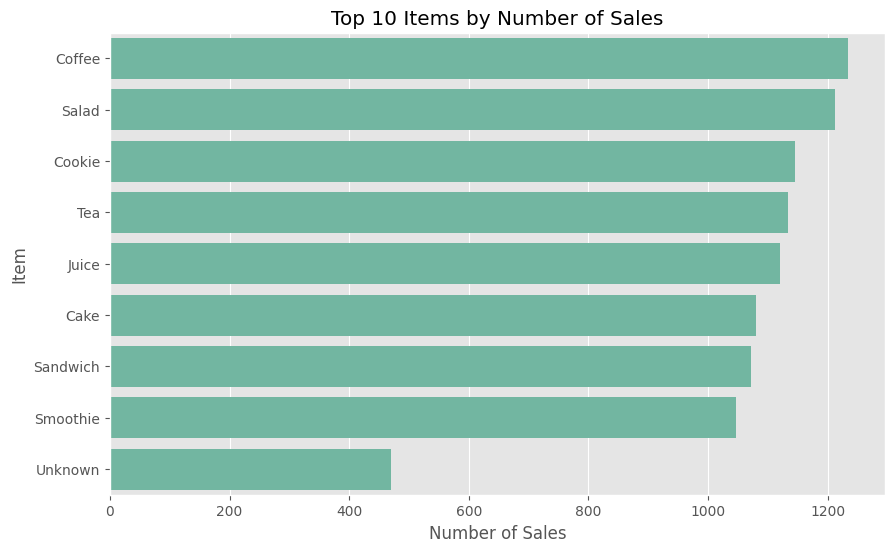

In [63]:
# 10.2 Top items by frequency
top_items = df_clean['Item'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_items.values, y=top_items.index)
plt.title('Top 10 Items by Number of Sales')
plt.xlabel('Number of Sales')
plt.ylabel('Item')
plt.show()

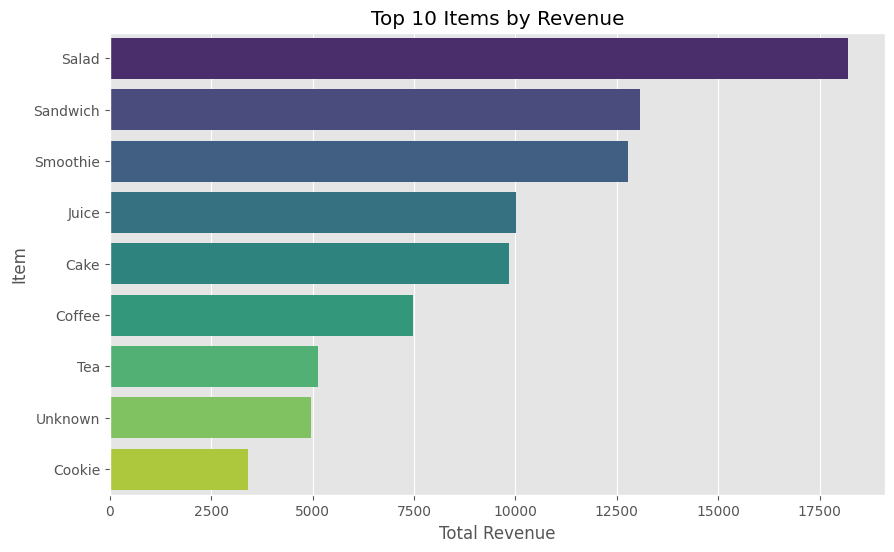

In [64]:
# 10.3 Top items by revenue
revenue_per_item = df_clean.groupby('Item')['Total_Spent'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=revenue_per_item.values, y=revenue_per_item.index, palette='viridis')
plt.title('Top 10 Items by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Item')
plt.show()

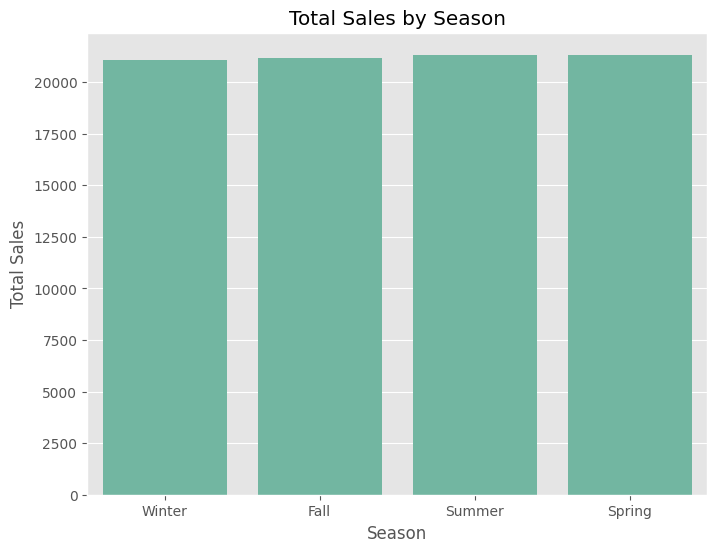

In [65]:
# 10.4 Sales by season
season_sales = df_clean.groupby('Season')['Total_Spent'].sum().sort_values()
plt.figure(figsize=(8,6))
sns.barplot(x=season_sales.index, y=season_sales.values)
plt.title('Total Sales by Season')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.show()

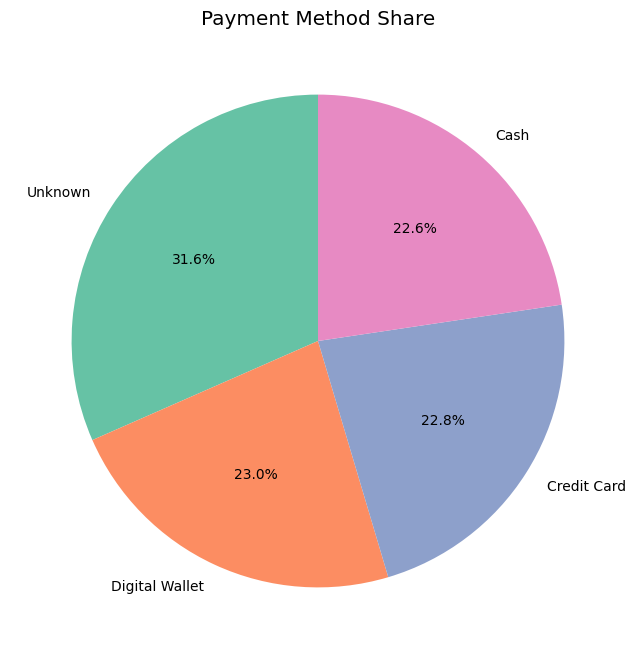

In [66]:
# 10.5 Payment method distribution
payment_counts = df_clean['Payment_Method'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(payment_counts.values, labels=payment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Payment Method Share')
plt.show()

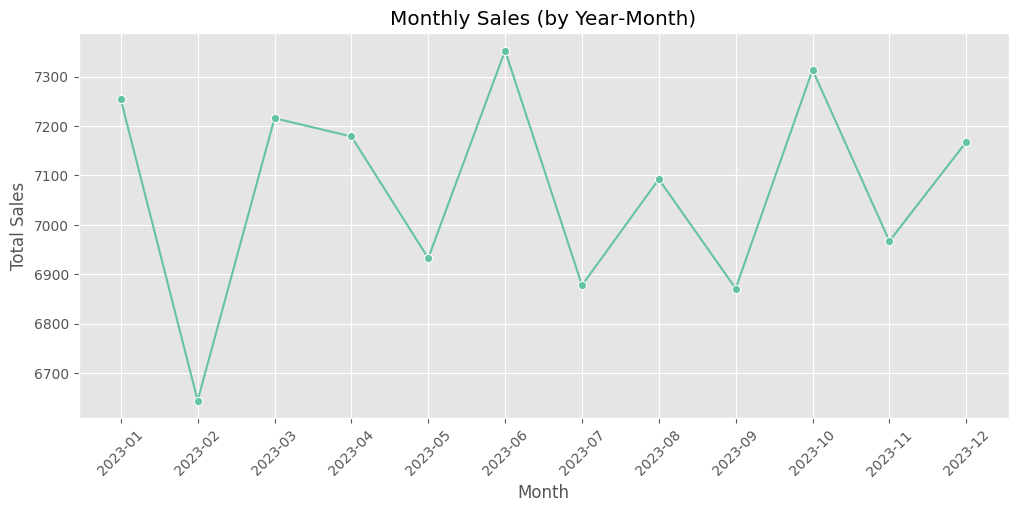

In [67]:
# ---- 10.6 Correct monthly trend (by year‑month) ----
df_clean['YearMonth'] = df_clean['Transaction_Date'].dt.to_period('M')
monthly_sales = df_clean.groupby('YearMonth')['Total_Spent'].sum()

# Convert Period to string for better x‑axis labels
monthly_sales.index = monthly_sales.index.astype(str)

plt.figure(figsize=(12,5))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title('Monthly Sales (by Year‑Month)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

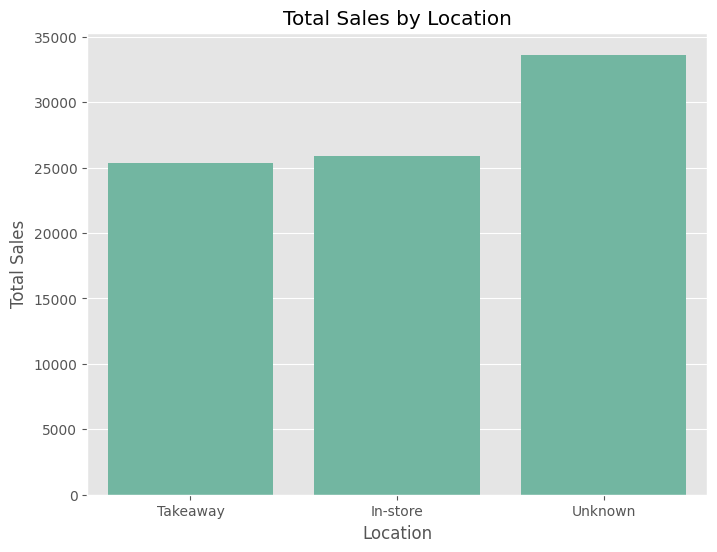

In [68]:
# 10.7 Sales by location
location_sales = df_clean.groupby('Location')['Total_Spent'].sum().sort_values()
plt.figure(figsize=(8,6))
sns.barplot(x=location_sales.index, y=location_sales.values)
plt.title('Total Sales by Location')
plt.xlabel('Location')
plt.ylabel('Total Sales')
plt.show()

## 11. Business Insights & Specific Recommendations

In [69]:
# Compute key metrics
total_transactions = len(df_clean)
total_revenue = df_clean['Total_Spent'].sum()
avg_ticket = df_clean['Total_Spent'].mean()

top_item_revenue = df_clean.groupby('Item')['Total_Spent'].sum().idxmax()
top_item_revenue_val = df_clean.groupby('Item')['Total_Spent'].sum().max()

top_item_freq = df_clean['Item'].value_counts().idxmax()
top_item_freq_val = df_clean['Item'].value_counts().max()

best_season = df_clean.groupby('Season')['Total_Spent'].sum().idxmax()
best_season_val = df_clean.groupby('Season')['Total_Spent'].sum().max()
worst_season = df_clean.groupby('Season')['Total_Spent'].sum().idxmin()

top_payment = df_clean['Payment_Method'].value_counts().idxmax()
top_payment_count = df_clean['Payment_Method'].value_counts().max()
top_payment_pct = (top_payment_count / total_transactions) * 100

in_store_sales = df_clean[df_clean['Location'] == 'In-store']['Total_Spent'].sum()
takeaway_sales = df_clean[df_clean['Location'] == 'Takeaway']['Total_Spent'].sum()

print('=== KEY INSIGHTS ===')
print()
print(f'- Total cleaned transactions: {total_transactions:,}')
print(f'- Total revenue: ${total_revenue:,.2f}')
print(f'- Average ticket: ${avg_ticket:.2f}')
print(f'- Highest revenue item: "{top_item_revenue}" (${top_item_revenue_val:,.2f})')
print(f'- Most frequently sold item: "{top_item_freq}" ({top_item_freq_val} times)')
print(f'- Best performing season: {best_season} (${best_season_val:,.2f})')
print(f'- Worst performing season: {worst_season}')
print(f'- Dominant payment method: {top_payment} ({top_payment_count} transactions, {top_payment_pct:.1f}%)')
print(f'- In-store vs Takeaway revenue: ${in_store_sales:,.2f} vs ${takeaway_sales:,.2f}')

print()
print('=== ACTIONABLE RECOMMENDATIONS ===')
print(f'1. Since "{top_item_revenue}" generates the highest revenue (${top_item_revenue_val:,.2f}), consider bundling it with lower-selling items (e.g., "{df_clean.groupby("Item")["Total_Spent"].sum().nsmallest(1).index[0]}") to boost overall sales.')

if top_payment == 'Unknown':
    print('2. Payment method is frequently missing ("Unknown"). Improve data capture at POS/online checkout before drawing conclusions about payment preferences.')
else:
    print(f'2. {top_payment} is used in {top_payment_pct:.1f}% of transactions. Ensure the payment infrastructure for this method is reliable and consider loyalty incentives.')

print(f'3. {best_season} is the peak season; prepare inventory and staffing accordingly. In the weakest season ({worst_season}), launch targeted promotions such as discounts or special menu items.')
print('4. The revenue split between In-store and Takeaway is nearly equal; if Takeaway is slightly lower, consider offering a small discount for takeaway orders to balance load or improve packaging.')


=== KEY INSIGHTS ===

- Total cleaned transactions: 9,514
- Total revenue: $84,868.50
- Average ticket: $8.92
- Highest revenue item: "Salad" ($18,200.00)
- Most frequently sold item: "Coffee" (1234 times)
- Best performing season: Spring ($21,327.50)
- Worst performing season: Winter
- Dominant payment method: Unknown (3005 transactions, 31.6%)
- In-store vs Takeaway revenue: $25,851.50 vs $25,386.50

=== ACTIONABLE RECOMMENDATIONS ===
1. Since "Salad" generates the highest revenue ($18,200.00), consider bundling it with lower-selling items (e.g., "Cookie") to boost overall sales.
2. Payment method is frequently missing ("Unknown"). Improve data capture at POS/online checkout before drawing conclusions about payment preferences.
3. Spring is the peak season; prepare inventory and staffing accordingly. In the weakest season (Winter), launch targeted promotions such as discounts or special menu items.
4. The revenue split between In-store and Takeaway is nearly equal; if Takeaway is sli

## 12. Save Cleaned Data

In [70]:
df_clean.to_csv('output/cleaned_cafe_sales.csv', index=False)
print('Cleaned data saved to output/cleaned_cafe_sales.csv')

Cleaned data saved to output/cleaned_cafe_sales.csv
